# A/B test 3 - loved journeys, control vs node2vec

This related links B/C test (ab3) was conducted from 15-20th 2019.

The data used in this report are 15-19th Mar 2019 because the test was ended on 20th mar.

The test compared the existing related links (where available) to links generated using node2vec algorithm 

## Import

In [83]:
%load_ext autoreload
%autoreload 2

import os 
import pandas as pd
import numpy as np
import ast
import re

# z test
from statsmodels.stats.proportion import proportions_ztest

# bayesian bootstrap and vis
import matplotlib.pyplot as plt
import seaborn as sns
import bayesian_bootstrap.bootstrap as bb
from astropy.utils import NumpyRNGContext

# progress bar
from tqdm import tqdm, tqdm_notebook

from scipy import stats
from collections import Counter

import sys
sys.path.insert(0, '../../src' )
import analysis as analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set up the style for our plots
sns.set(style='white', palette='colorblind', font_scale=1.3,
        rc={'figure.figsize':(12,9), 
            "axes.facecolor": (0, 0, 0, 0)})

# instantiate progress bar goodness
tqdm.pandas(tqdm_notebook)

pd.set_option('max_colwidth',500)

# the number of bootstrap means used to generate a distribution
boot_reps = 10000

# alpha - false positive rate
alpha = 0.05
# number of tests
m = 4
# Correct alpha for multiple comparisons
alpha = alpha / m

# The Bonferroni correction can be used to adjust confidence intervals also. 
# If one establishes m confidence intervals, and wishes to have an overall confidence level of 1-alpha,
# each individual confidence interval can be adjusted to the level of 1-(alpha/m).

# reproducible
seed = 1337

## File/dir locations
### Processed journey data

In [3]:
DATA_DIR = os.getenv("DATA_DIR")
filename = "full_sample_loved_947858.csv.gz"
filepath = os.path.join(
    DATA_DIR, "sampled_journey", "20190315_20190319",
    filename)
filepath

'/Users/ellieking/Documents/govuk_ab_analysis/data/sampled_journey/20190315_20190319/full_sample_loved_947858.csv.gz'

In [6]:
VARIANT_DICT = {
    'CONTROL_GROUP':'B',
    'INTERVENTION_GROUP':'C'
}

In [4]:
# read in processed sampled journey with just the cols we need for related links
df = pd.read_csv(filepath, sep ="\t", compression="gzip")
# convert from str to list
df['Event_cat_act_agg']= df['Event_cat_act_agg'].progress_apply(ast.literal_eval)
df['Page_Event_List'] = df['Page_Event_List'].progress_apply(ast.literal_eval)
df['Page_List'] = df['Page_List'].progress_apply(ast.literal_eval)

100%|██████████| 740885/740885 [00:15<00:00, 47142.59it/s]


In [7]:
# drop dodgy rows, where page variant is not A or B.
df = df.query('ABVariant in [@CONTROL_GROUP, @INTERVENTION_GROUP]')

In [8]:
df[['Occurrences', 'ABVariant']].groupby('ABVariant').sum()

,Occurrences
ABVariant,
B,947858
C,947858


In [5]:
df['Page_List_Length'] = df['Page_List'].progress_apply(len)


100%|██████████| 740885/740885 [00:00<00:00, 766377.92it/s]


### Nav type of page lookup - is it a finding page? if not it's a thing page

In [9]:
filename = "document_types.csv.gz"

# created a metadata dir in the DATA_DIR to hold this data
filepath = os.path.join(
    DATA_DIR, "metadata",
    filename)
print(filepath)

df_finding_thing = pd.read_csv(filepath, sep="\t", compression="gzip")

df_finding_thing.head()

/Users/ellieking/Documents/govuk_ab_analysis/data/metadata/document_types.csv.gz


,pagePath,is_finding
0,/jobsearch,0
1,/pay-leave-for-parents/y,0
2,/student-finance-calculator/y/2018-2019/uk-full-time,0
3,/government/publications/application-for-confirmation-of-british-nationality-status-form-ns,0
4,/pip/eligibility,0


In [10]:
thing_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==0]['pagePath'].tolist()


finding_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==1]['pagePath'].tolist()

## Outliers
Some rows should be removed before analysis. For example rows with journey lengths of 500 or very high related link click rates. This process might have to happen once features have been created.

# Derive variables

## journey_click_rate
There is no difference in the proportion of journeys using at least one related link (journey_click_rate) between page variant A and page variant B.



\begin{equation*}
\frac{\text{total number of journeys including at least one click on a related link}}{\text{total number of journeys}}
\end{equation*}

In [11]:
# get the number of related links clicks per Sequence
df['Related Links Clicks per seq'] = df['Event_cat_act_agg'].map(analysis.sum_related_click_events)

In [12]:
# map across the Sequence variable, which includes pages and Events
# we want to pass all the list elements to a function one-by-one and then collect the output.
df["Has_Related"] = df["Related Links Clicks per seq"].map(analysis.is_related)

df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']


In [13]:
df.head(3)

,ABVariant,Page_Event_List,Page_List,Event_cat_act_agg,Occurrences,Page_List_Length,Related Links Clicks per seq,Has_Related,Related Links Clicks row total
0,B,"[(/ <span class=, PAGE<:<NULL<:<NULL, other), (/search?q=countersign, PAGE<:<NULL<:<NULL, other), (/search?q=countersign, EVENT<:<searchResults<:<resultsShown, other), (/search?q=countersign, EVENT<:<UX<:<click, other), (/countersigning-passport-applications, PAGE<:<NULL<:<NULL, 27b9c5cd-b390-4332-89be-73491df35a41), (/countersigning-passport-applications, EVENT<:<contentsClicked<:<content_item 2, 27b9c5cd-b390-4332-89be-73491df35a41), (/countersigning-passport-applications/accepted-occupati...","[/ <span class=, /search?q=countersign, /countersigning-passport-applications, /countersigning-passport-applications/accepted-occupations-for-countersignatories, /, /, /browse/abroad, /browse/abroad/passports, /overseas-passports, /browse/abroad/passports, /report-a-lost-or-stolen-passport, /report-a-lost-or-stolen-passport/y, /report-a-lost-or-stolen-passport/y/in_the_uk]","[((PAGE_NULL, PAGE_NULL), 13), ((searchResults, resultsShown), 1), ((UX, click), 1), ((contentsClicked, content_item 2), 1), ((secondLevelBrowseLinkClicked, 2), 1), ((thirdLevelBrowseLinkClicked, 2.1), 1), ((thirdLevelBrowseLinkClicked, 3.1), 1), ((Smart Answer, Completed), 1), ((External Link Clicked, https://www.loststolenpassport.service.gov.uk/report/passport-holder), 1)]",1,13,0,False,0
1,B,"[(/ new style employment support allowance, PAGE<:<NULL<:<NULL, other), (/employment support allowance, PAGE<:<NULL<:<NULL, other), (/ new style employment allowance, EVENT<:<user_satisfaction_survey<:<banner_shown, other), (/ new style employment allowance, PAGE<:<NULL<:<NULL, other), (/ universal creit, PAGE<:<NULL<:<NULL, other), (/how-to-claim-new-style-esa, PAGE<:<NULL<:<NULL, 05a9527b-e6e9-4a68-8dd7-7d84e6a24eef), (/how-to-claim-new-style-esa, EVENT<:<pageElementInteraction<:<stepNavSh...","[/ new style employment support allowance, /employment support allowance, / new style employment allowance, / universal creit, /how-to-claim-new-style-esa, /employment-support-allowance/how-to-claim?step-by-step-nav=a661e652-204c-4abf-a2ce-9f183aca85b9, /government/publications/new-style-employment-and-support-allowance-esa-claim-form]","[((PAGE_NULL, PAGE_NULL), 7), ((user_satisfaction_survey, banner_shown), 1), ((pageElementInteraction, stepNavShown), 1), ((stepNavLinkClicked, 2.1), 1), ((External Link Clicked, https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/781870/nsesaf1-interactive.pdf), 1), ((Download Link Clicked, https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/781870/nsesaf1-interactive.pdf), 1)]",1,7,0,False,0
2,B,"[(/ tell-us-once, PAGE<:<NULL<:<NULL, other), (/after-a-death/organisations-you-need-to-contact-and-tell-us-once, PAGE<:<NULL<:<NULL, eed5b92e-8279-4ca9-a141-5c35ed22fcf1,f875c256-b84a-417a-b2b5-ff7e301a41c7,0fffa994-b76d-4539-8bf9-2a6c6751580d), (/after-a-death/organisations-you-need-to-contact-and-tell-us-once, EVENT<:<External Link Clicked<:<https://tell-us-someone-died.dwp.gov.uk/death/enrich/recover, eed5b92e-8279-4ca9-a141-5c35ed22fcf1,f875c256-b84a-417a-b2b5-ff7e301a41c7,0fffa994-b76d...","[/ tell-us-once, /after-a-death/organisations-you-need-to-contact-and-tell-us-once]","[((PAGE_NULL, PAGE_NULL), 2), ((External Link Clicked, https://tell-us-someone-died.dwp.gov.uk/death/enrich/recover), 1)]",2,2,0,False,0


## count of clicks on navigation elements

There is no statistically significant difference in the count of clicks on navigation elements per journey between page variant A and page variant B.

\begin{equation*}
{\text{total number of navigation element click events from content pages}}
\end{equation*}

### Related link counts

In [14]:
# get the total number of related links clicks for that row (clicks per sequence multiplied by occurrences)
df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']

### Navigation events

In [15]:
def count_nav_events(page_event_list):
    """Counts the number of nav events from a content page in a Page Event List."""
    content_page_nav_events = 0
    for pair in page_event_list:
        if analysis.is_nav_event(pair[1]):
            if pair[0] in thing_page_paths:
                content_page_nav_events += 1
    return content_page_nav_events

In [16]:
# needs finding_thing_df read in from document_types.csv.gz
df['Content_Page_Nav_Event_Count'] = df['Page_Event_List'].progress_map(count_nav_events)

100%|██████████| 740885/740885 [15:57<00:00, 773.42it/s]


In [17]:
def count_search_from_content(page_list):
    search_from_content = 0
    for i, page in enumerate(page_list):
        if i > 0:
            if '/search?q=' in page:
                if page_list[i-1] in thing_page_paths:
                    search_from_content += 1
    return search_from_content

In [18]:
df['Content_Search_Event_Count'] = df['Page_List'].progress_map(count_search_from_content)

100%|██████████| 740885/740885 [37:56<00:00, 325.50it/s]


In [19]:
# count of nav or search clicks
df['Content_Nav_or_Search_Count'] = df['Content_Page_Nav_Event_Count'] + df['Content_Search_Event_Count']
# occurrences is accounted for by the group by bit in our bayesian boot analysis function
df['Content_Nav_Search_Event_Sum_row_total'] = df['Content_Nav_or_Search_Count'] * df['Occurrences']
# required for journeys with no nav later
df['Has_No_Nav_Or_Search'] = df['Content_Nav_Search_Event_Sum_row_total'] == 0

## Temporary df file in case of crash
### Save

In [20]:
df.to_csv(os.path.join(
    DATA_DIR, 
    "ab3_loved_temp.csv.gz"), sep="\t", compression="gzip", index=False)

In [75]:
df = pd.read_csv(os.path.join(
    DATA_DIR, 
    "ab3_loved_temp.csv.gz"), sep="\t", compression="gzip")

### Frequentist statistics

#### Statistical significance

In [19]:
# help(proportions_ztest)

In [78]:
has_rel = analysis.z_prop(df, 'Has_Related', VARIANT_DICT)
has_rel

{'metric_name': 'Has_Related',
 'stats_method': 'z_prop_test',
 'x_ab': 80423,
 'n_ab': 1895716,
 'p': 0.0424235486750125,
 'x_a': 32938,
 'n_a': 947858,
 'p_a': 0.0347499308968221,
 'x_b': 47485,
 'n_b': 947858,
 'p_b': 0.050097166453202904,
 'test_statistic': -52.41994674750953,
 'p-value': 0.0}

In [22]:
has_rel['p-value'] < alpha

True

#### Practical significance - uplift

In [23]:
# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = analysis.zconf_interval_two_samples(has_rel['x_a'], has_rel['n_a'],
                                           has_rel['x_b'], has_rel['n_b'], alpha = alpha)
print(' difference in proportions = {0:.2f}%'.format(100*(has_rel['p_b']-has_rel['p_a'])))
print(' % relative change in proportions = {0:.2f}%'.format(100*((has_rel['p_b']-has_rel['p_a'])/has_rel['p_a'])))
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 difference in proportions = 1.53%
 % relative change in proportions = 44.16%
 95% Confidence Interval = ( 1.46% , 1.61% )


### Bayesian statistics 

Based on [this](https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd) blog

To be developed, a Bayesian approach can provide a simpler interpretation.

### Bayesian bootstrap

In [95]:
analysis.compare_total_searches(df, VARIANT_DICT)

total searches in control group = 55473
total searches in intervention group = 52052
intervention has 3421 fewer navigation or searches than control;
a 3.18% overall difference
The relative change was -6.17% from control to intervention


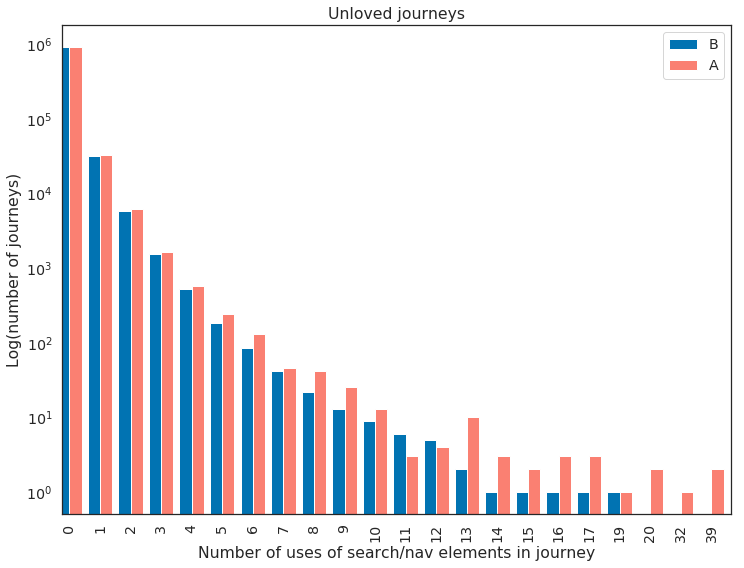

In [27]:
fig, ax = plt.subplots()
plot_df_B = df[df.ABVariant == VARIANT_DICT['INTERVENTION_GROUP']].groupby(
            'Content_Nav_or_Search_Count').sum().iloc[:, 0]
plot_df_A = df[df.ABVariant == VARIANT_DICT['CONTROL_GROUP']].groupby(
            'Content_Nav_or_Search_Count').sum().iloc[:, 0]

ax.set_yscale('log')
width =0.4
ax = plot_df_B.plot.bar(label='B', position=1, width=width)
ax = plot_df_A.plot.bar(label='A', color='salmon', position=0, width=width)
plt.title("loved journeys")
plt.ylabel("Log(number of journeys)")
plt.xlabel("Number of uses of search/nav elements in journey")

legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig('nav_counts_loved_bar.png', dpi = 900, bbox_inches = 'tight')

In [28]:
a_bootstrap, b_bootstrap = analysis.bayesian_bootstrap_analysis(df, col_name='Content_Nav_or_Search_Count', boot_reps=boot_reps, seed = seed, variant_dict=VARIANT_DICT)

In [29]:
np.array(a_bootstrap).mean()

0.0585252161160608

In [30]:
np.array(a_bootstrap).mean() - (0.05 * np.array(a_bootstrap).mean())

0.055598955310257756

In [31]:
np.array(b_bootstrap).mean()

0.054913409515540704

In [32]:
print("A relative change of {0:.2f}% from control to intervention".format((np.array(b_bootstrap).mean()-np.array(a_bootstrap).mean())/np.array(a_bootstrap).mean()*100))

A relative change of -6.17% from control to intervention


In [33]:
# ratio is vestigial but we keep it here for convenience
# it's actually a count but considers occurrences
ratio_stats = analysis.bb_hdi(a_bootstrap, b_bootstrap, alpha=alpha)
ratio_stats

{'a_ci_low': 0.05767489219212566,
 'a_ci_hi': 0.05939884020632587,
 'b_ci_low': 0.05415420118463625,
 'b_ci_hi': 0.05572764281780729,
 'diff_mean': -0.0036118066005200915,
 'diff_ci_low': -0.004770971459678509,
 'diff_ci_hi': -0.0024054389997342773,
 'prob_b_>_a': 0.0}

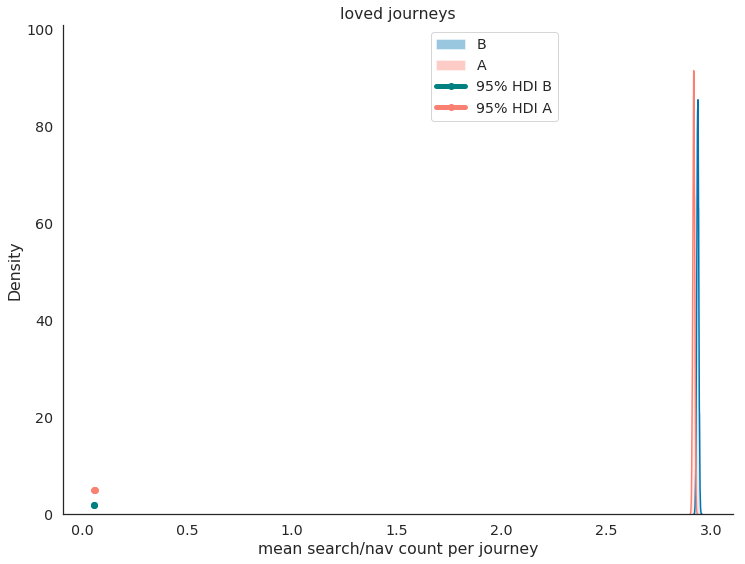

In [72]:
ax = sns.distplot(b_bootstrap, label='B')
ax.errorbar(x=[ratio_stats['b_ci_low'], ratio_stats['b_ci_hi']], y=[2, 2], linewidth=5, c='teal', marker='o', 
         label='95% HDI B')

ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.errorbar(x=[ratio_stats['a_ci_low'], ratio_stats['a_ci_hi']], y=[5, 5], linewidth=5, c='salmon', marker='o', 
         label='95% HDI A')

ax.set(xlabel='mean search/nav count per journey', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True, bbox_to_anchor=(0.75, 1), loc='best')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title("loved journeys")

plt.savefig('nav_counts_loved.png', dpi = 900, bbox_inches = 'tight')

In [35]:
# calculate the posterior for the difference between A's and B's ratio
# ypa prefix is vestigial from blog post
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

# the mean of the posterior
print('mean:', ypa_diff.mean())

print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)

mean: -0.0036118066005200915
low ci: -0.004526914146546164 
high ci: -0.002678271951587055


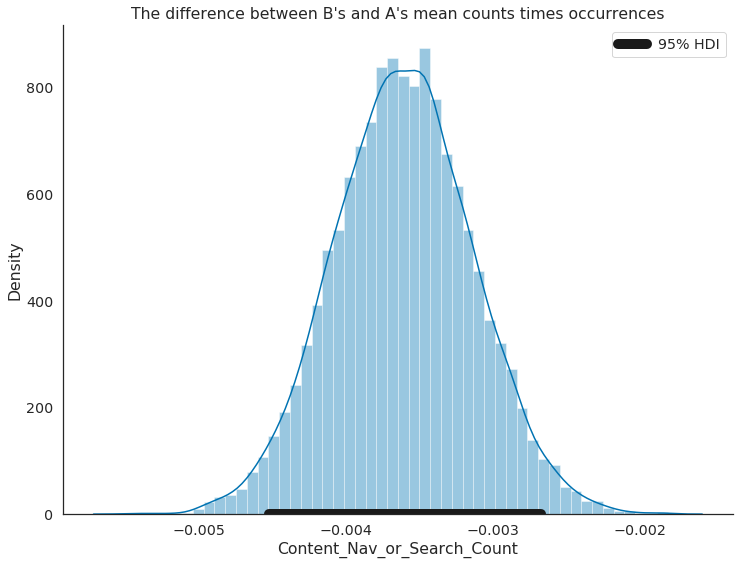

In [36]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Content_Nav_or_Search_Count', ylabel='Density', 
       title='The difference between B\'s and A\'s mean counts times occurrences')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

In [37]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.0

In [38]:
# We count the number of values less than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# less than 0, could act a bit like a p-value
(ypa_diff < 0).sum() / ypa_diff.shape[0]

1.0

In [39]:
(ypa_diff>0).sum()

0

In [40]:
(ypa_diff<0).sum()

10000

## proportion of journeys with a page sequence including content and related links only

There is no statistically significant difference in the proportion of journeys with a page sequence including content and related links only (including loops) between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of journeys that only contain content pages and related links (i.e. no nav pages)}}{\text{total number of journeys}}
\end{equation*}

### Overall

In [41]:
# if (Content_Nav_Search_Event_Sum == 0) that's our success
# Has_No_Nav_Or_Search == 1 is a success
# the problem is symmetrical so doesn't matter too much
sum(df.Has_No_Nav_Or_Search * df.Occurrences) / df.Occurrences.sum()

0.9572161652905815

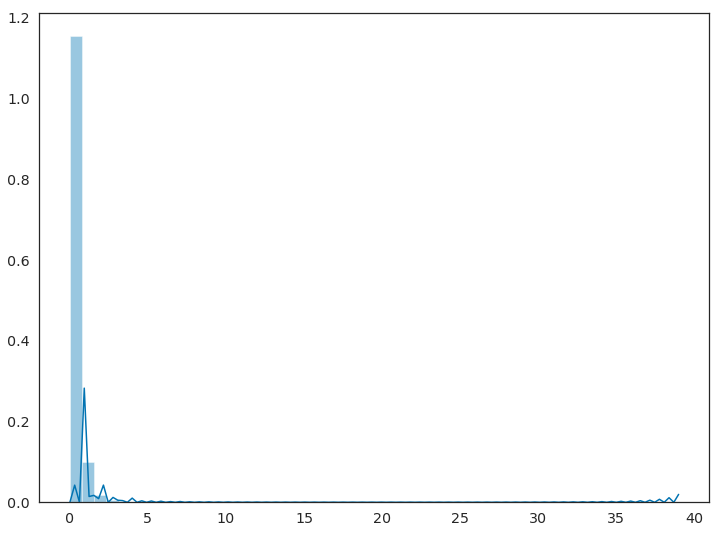

In [42]:
sns.distplot(df.Content_Nav_or_Search_Count.values);

### Frequentist statistics
#### Statistical significance

In [43]:
nav = analysis.z_prop(df, 'Has_No_Nav_Or_Search', VARIANT_DICT)
nav

{'metric_name': 'Has_No_Nav_Or_Search',
 'stats_method': 'z_prop_test',
 'x_ab': 1814610,
 'n_ab': 1895716,
 'p': 0.9572161652905815,
 'x_a': 906492,
 'n_a': 947858,
 'p_a': 0.9563584418763148,
 'x_b': 908118,
 'n_b': 947858,
 'p_b': 0.9580738887048482,
 'test_statistic': -5.835647323025062,
 'p-value': 5.358212752802185e-09}

#### Practical significance - uplift

In [44]:
# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = analysis.zconf_interval_two_samples(nav['x_a'], nav['n_a'],
                                           nav['x_b'], nav['n_b'], alpha = alpha)
diff = 100*(nav['x_b']/nav['n_b']-nav['x_a']/nav['n_a'])
print(' difference in proportions = {0:.2f}%'.format(diff))
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 difference in proportions = 0.17%
 95% Confidence Interval = ( 0.10% , 0.24% )


In [45]:
print("There was a {0: .2f}% relative change in the proportion of journeys not using search/nav elements".format(100 * ((nav['p_b']-nav['p_a'])/nav['p_a'])))

There was a  0.18% relative change in the proportion of journeys not using search/nav elements


## Average Journey Length (number of page views)
There is no statistically significant difference in the average page list length of journeys (including loops) between page variant A and page variant B.

In [46]:
length_B = df[df.ABVariant == VARIANT_DICT['INTERVENTION_GROUP']].groupby(
            'Page_List_Length').sum().iloc[:, 0]
lengthB_2 = length_B.reindex(np.arange(1, 501, 1), fill_value=0)

length_A = df[df.ABVariant == VARIANT_DICT['CONTROL_GROUP']].groupby(
            'Page_List_Length').sum().iloc[:, 0]
lengthA_2 = length_A.reindex(np.arange(1, 501, 1), fill_value=0)

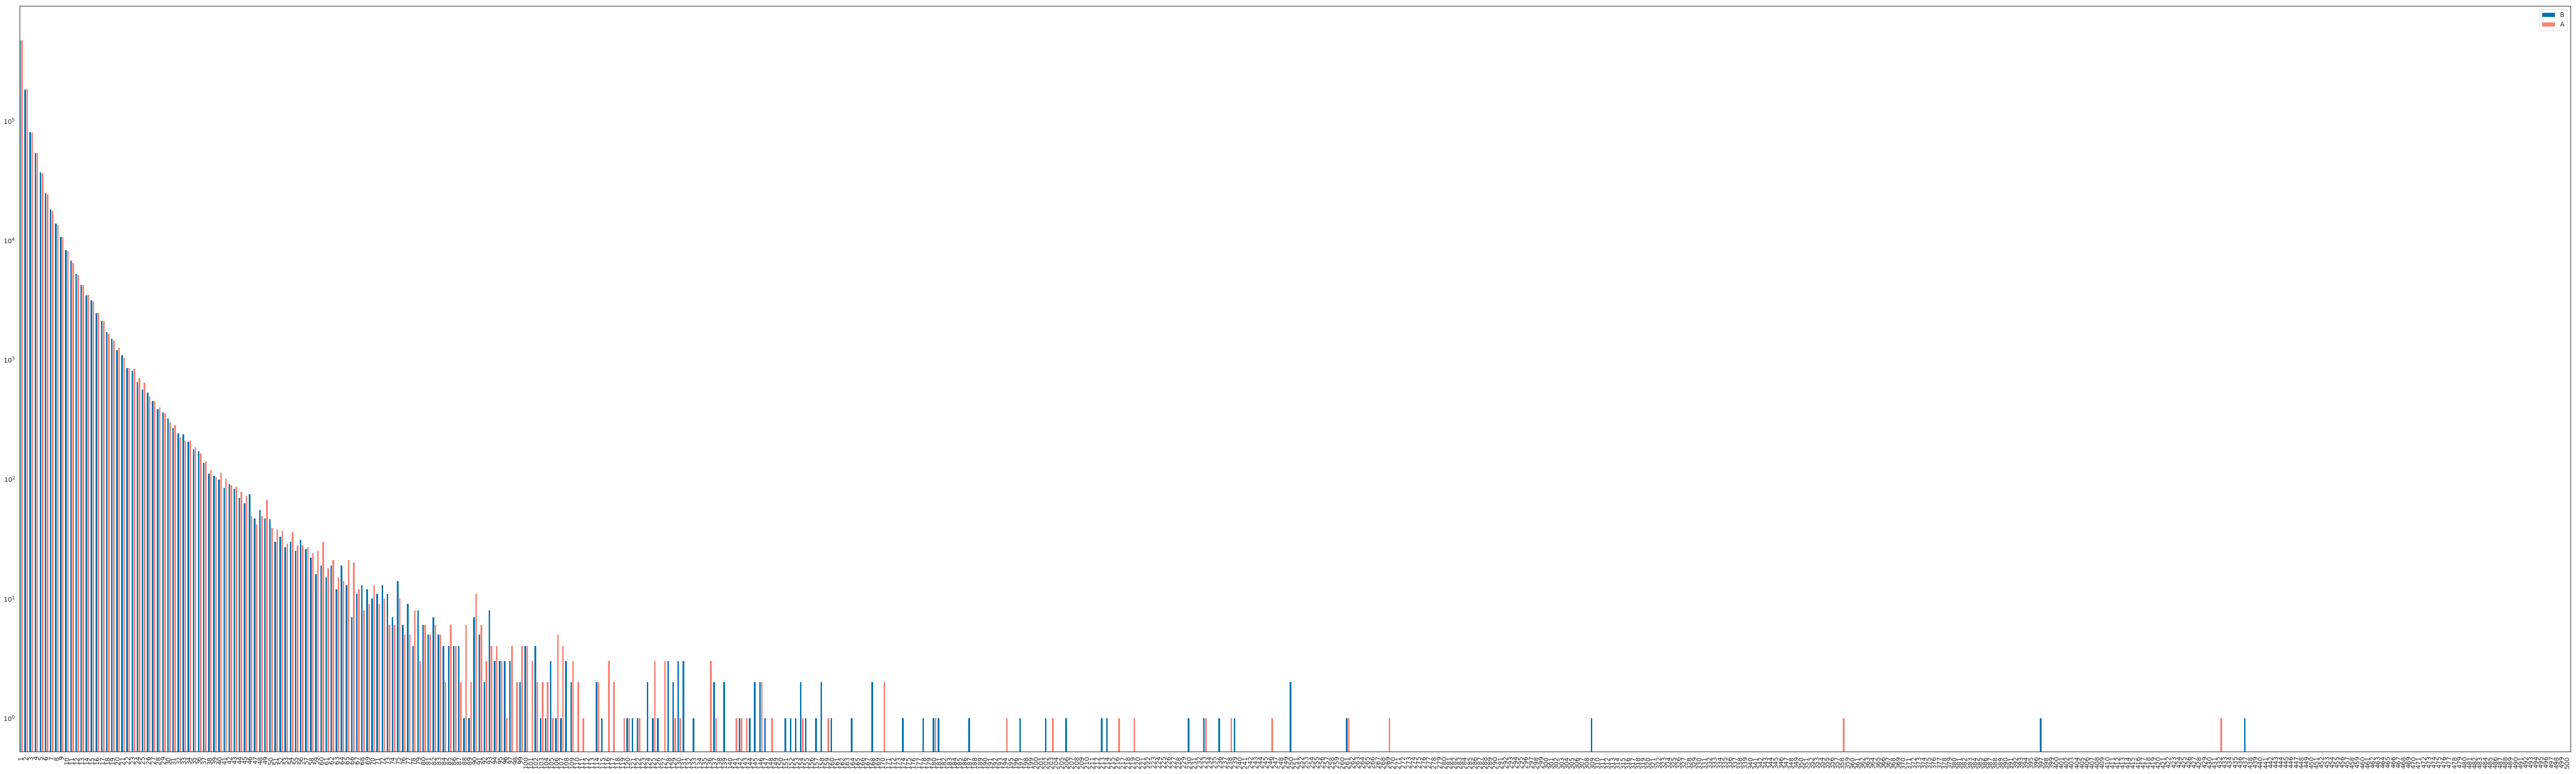

In [47]:
fig, ax = plt.subplots(figsize=(100, 30))

ax.set_yscale('log')
width = 0.4
ax = lengthB_2.plot.bar(label='B', position=1, width=width)
ax = lengthA_2.plot.bar(label='A', color='salmon', position=0, width=width)
plt.xlabel('length', fontsize=1)
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

### Bayesian bootstrap for non-parametric hypotheses

In [48]:
# http://savvastjortjoglou.com/nfl-bayesian-bootstrap.html

In [49]:
# let's use mean journey length (could probably model parametrically but we use it for demonstration here)
# some journeys have length 500 and should probably be removed as they are liekely bots or other weirdness

In [50]:
#exclude journeys of longer than 500 as these could be automated traffic

In [51]:
df_short = df[df['Page_List_Length'] < 500]

In [70]:
print("The mean number of pages in an loved journey is {0:.3f}".format(sum(df.Page_List_Length*df.Occurrences)/df.Occurrences.sum()))

The mean number of pages in an loved journey is 2.925


In [53]:
# for reproducibility, set the seed within this context
a_bootstrap, b_bootstrap = analysis.bayesian_bootstrap_analysis(df, col_name='Page_List_Length', boot_reps=boot_reps, seed = seed, variant_dict=VARIANT_DICT)
a_bootstrap_short, b_bootstrap_short = analysis.bayesian_bootstrap_analysis(df_short, col_name='Page_List_Length', boot_reps=boot_reps, seed = seed, variant_dict=VARIANT_DICT)

In [54]:
np.array(a_bootstrap).mean()

2.915517748374824

In [55]:
np.array(b_bootstrap).mean()

2.934754208109922

In [56]:
print("There's a relative change in page length of {0:.2f}% from A to B".format((np.array(b_bootstrap).mean()-np.array(a_bootstrap).mean())/np.array(a_bootstrap).mean()*100))

There's a relative change in page length of 0.66% from A to B


In [57]:
print(np.array(a_bootstrap_short).mean())
print(np.array(b_bootstrap_short).mean())

2.915517748374824
2.934754208109922


In [58]:
# Calculate a 95% HDI
a_ci_low, a_ci_hi = bb.highest_density_interval(a_bootstrap)
print('low ci:', a_ci_low, '\nhigh ci:', a_ci_hi)

low ci: 2.9067864815468747 
high ci: 2.9243293080699546


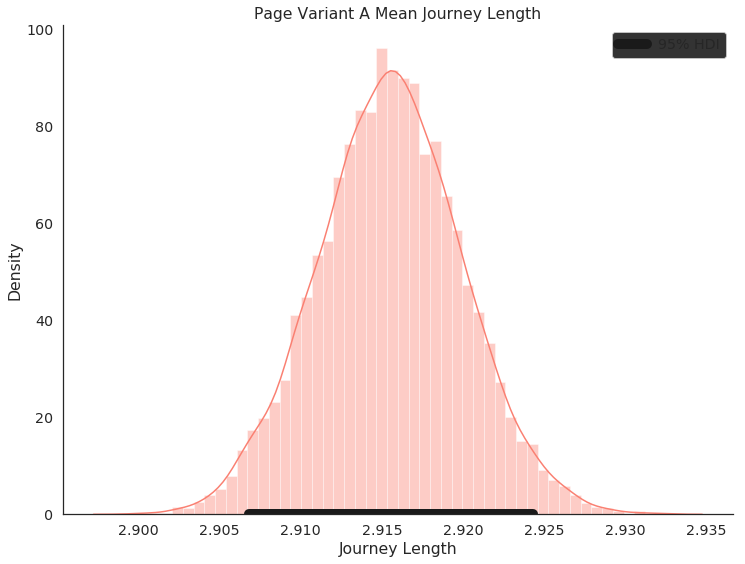

In [59]:
ax = sns.distplot(a_bootstrap, color='salmon')
ax.plot([a_ci_low, a_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant A Mean Journey Length')
sns.despine()
plt.legend();

In [60]:
# Calculate a 95% HDI
b_ci_low, b_ci_hi = bb.highest_density_interval(b_bootstrap)
print('low ci:', b_ci_low, '\nhigh ci:', b_ci_hi)

low ci: 2.925637198049479 
high ci: 2.9435603551617002


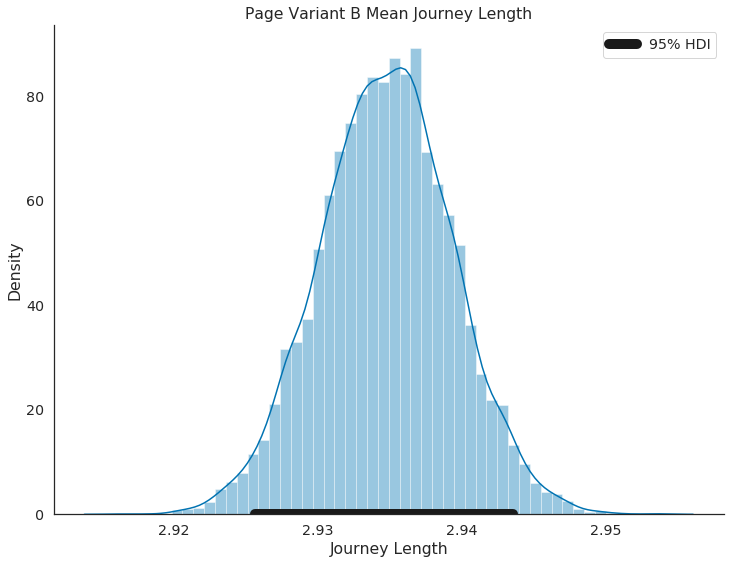

In [61]:
ax = sns.distplot(b_bootstrap)
ax.plot([b_ci_low, b_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant B Mean Journey Length')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

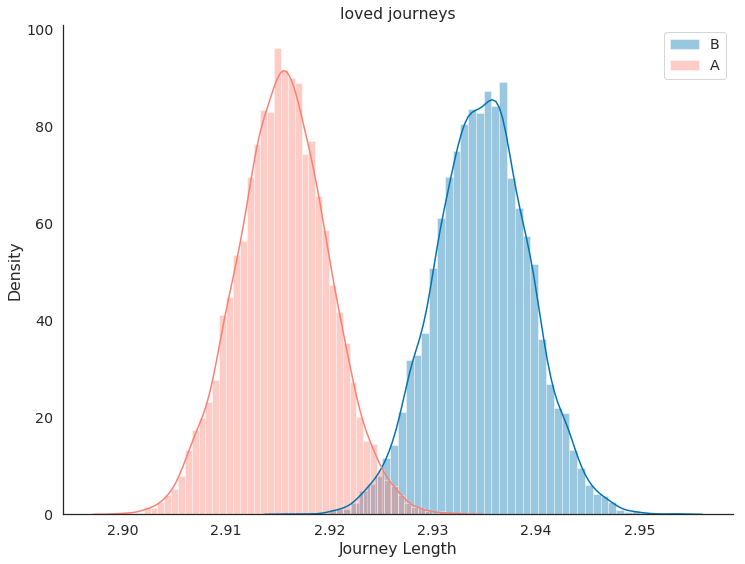

In [71]:
ax = sns.distplot(b_bootstrap, label='B')
ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title("loved journeys")

plt.savefig('journey_length_loved.png', dpi = 900, bbox_inches = 'tight')

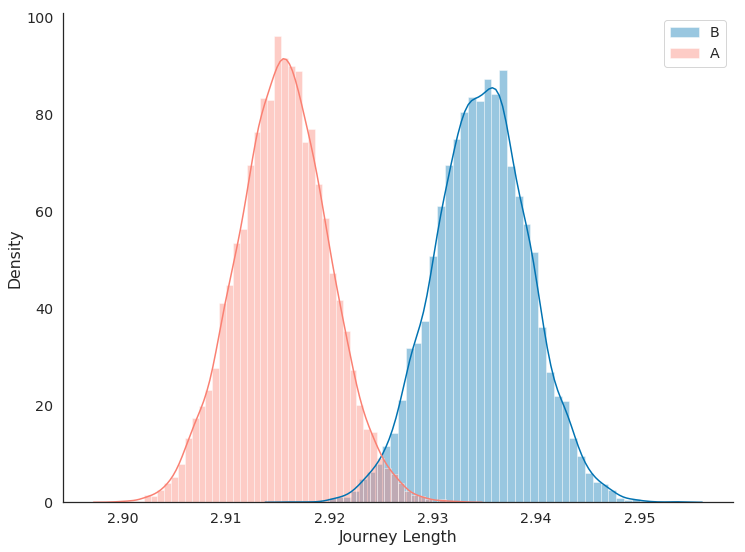

In [63]:
ax = sns.distplot(b_bootstrap_short, label='B')
ax = sns.distplot(a_bootstrap_short, label='A', ax=ax, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

We can also measure the uncertainty in the difference between the Page Variants's Journey Length by subtracting their posteriors.



In [64]:
# calculate the posterior for the difference between A's and B's YPA
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

In [65]:
# the mean of the posterior
ypa_diff.mean()

0.01923645973509877

In [66]:
print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)


low ci: 0.0068061407105859395 
high ci: 0.031673290308020796


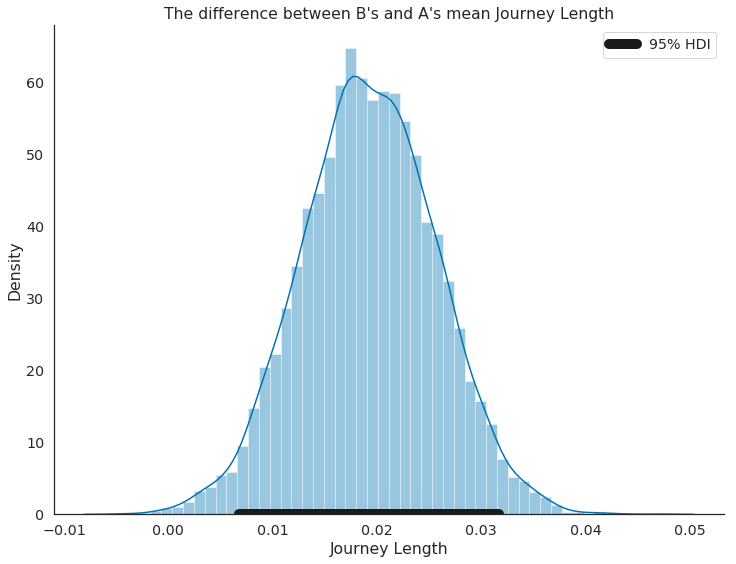

In [67]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', 
       title='The difference between B\'s and A\'s mean Journey Length')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

We can actually calculate the probability that B's mean Journey Length was greater than A's mean Journey Length by measuring the proportion of values greater than 0 in the above distribution.

In [68]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.9987

In [69]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff < 0).sum() / ypa_diff.shape[0]

0.0013